# Prompt 
* HW assignment: Using dataset selected for final project:

* Perform feature engineering
* Estimate baseline model
* Estimate different model and/or different loss function to improve model performance
* Hint: Determine what metric(s) is/are appropriate for your use case
* Interpret results
* Explain what you did and why

## Write-up
* Goal: Forecast the last 6 weeks of the time series for each store.
* Kaggle Prompt: Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. In their first Kaggle competition, Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams! 

**Variable Importance**

I first utilize a GBM in order to see if it can quickly tell me which variables are important or not. I do not set this up as a normal time series forecasting question, so I don't add any lags (prev day, week, month). I also don't split the dataset by time series and I don't force the train/test to not overlap. However, using the output, I am able to see that the following variables are important: 

    1. "Open": if store is open
    2. "Promo": if that Day is a promo day
    3. "CompetitionDistance": nearest competitor distance
    
**Feature Engineering**

I honestly couldn't think of a ton of different features to add. I did think that adding in that day's distance to the previous open day and the previous promo day could be promising, given how important those features seemed to be.

**1st Attempt: Prophet w/o addtl regressors**
As a baseline model, I decided to use <a href="https://research.fb.com/prophet-forecasting-at-scale/">Prophet from fb</a>. It's a time series model that I use as a baseline model because it doesn't make a ton of assumptions about the underlying data structure.

**2nd Attempt: Prophet w/ addtl regressors**
Additionally, it is very simple to implement and has the ability to add in additional regressors. The second version of the model included the regressors for the top 3 important variables as well as some of the features that I created, "daydiff_open_dt" and "daydiff_promo_dt". These variables represent the distance from the date being forecast to the previous day the store was open as well as the previous day that the store had a promo.

**Metric Selection**
The competition utilizes RMSPE (Root Mean Squared Percentage Error) and doesn't include any day with 0 sales. I think that this is good in that it penalizes large errors. However, I do not like the fact that we are looking at the error relative to the prediction, so I also recommend looking at RMSE (without 0 sale days). Since the competition says the purpose is to help the managers effectively staff their stores, I make the assumption that there are a certain number of salespeople per sales volume. The problem with RMSPE is: if there were only 1 store/day and we forecast 50,000 in sales and the actual came in at 100,000, the RMSPE would be 50%. Now, if there were only 1 store/day and we forecast 50 in sales and the actual came in at 100, the RMSPE would **also** be 50%. To me, the first seems like a much bigger error in terms of staffing (if there is some $/salespeople ratio). RMSE for the first scenario is 50,000 and 50 for the second.

**Interpreting Results**
Manually looking at some of the forecast graphs, the model looks like it does a pretty good job of picking up on Day of Week Seasonality. Because of the granularity of the data, I will need to dig further into how to interpret results at the store-level.

### Import Packages and Data

In [1]:
from multiprocessing import Pool, cpu_count
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.automl import H2OAutoML
from fbprophet import Prophet
import time
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from IPython.display import Audio
sound_file = 'https://www.soundjay.com/phone/telephone-ring-03a.wav'

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)
Audio(sound_file, autoplay=True)

In [2]:
pwd

'/home/paperspace/ANDREW-MINKYU-SANG/final_proj/workprod'

In [3]:
cd /home/paperspace/ANDREW-MINKYU-SANG/

/home/paperspace/ANDREW-MINKYU-SANG


In [4]:
# cd /Users/andrewsang/Documents/ucla_stats/

In [5]:
ls

Class0-Intro/  Class2/  Class4/  Class6/  final_proj/  req.txt
Class1/        Class3/  Class5/  Class7/  README.md    requirements.txt


In [7]:
typ_dict = {'Store':np.int8,
 'DayOfWeek':np.int8,
 'Date':object,
 'Sales':np.int8,
 'Customers':np.int8,
 'Open':np.int8,
 'Promo':np.int8,
 'StateHoliday':object,
 'SchoolHoliday':np.int8}

train = pd.read_csv('final_proj/input_data/train.csv',dtype=typ_dict)

Adding in the dictionary sped up the data load process. I did this because it seemed like something that would speed up the process. In a section below, I utilized multiprocessing in order to speed up a for-loop that I had been running.

In [8]:
test = pd.read_csv('final_proj/input_data/test.csv')
store = pd.read_csv('final_proj/input_data/store.csv')

In [9]:
# train.loc[:,'Date'] = pd.to_datetime(train['Date'])
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,-113,43,1,1,0,1
1,2,5,2015-07-31,-80,113,1,1,0,1
2,3,5,2015-07-31,122,53,1,1,0,1
3,4,5,2015-07-31,-85,-38,1,1,0,1
4,5,5,2015-07-31,-42,47,1,1,0,1


### Functions for Data Manipulation and Feature Engineering

In [244]:
def holiday_map(s):
    if s == '0':
        return 'd'
    elif s == 0:
        return 'e'
    else:
        return s

def data_manipulation(dataframe):
    dataframe = dataframe.merge(store,how='left',on='Store')
    mask = pd.isnull(dataframe['CompetitionDistance'])
    # replace 3 stores with median where competition distance is null
    dataframe.loc[mask,'CompetitionDistance'] = store['CompetitionDistance'].median() 
    # make state holiday consistent
    dataframe.loc[:,'StateHoliday'] = dataframe['StateHoliday'].map(lambda s:holiday_map(s))
    return dataframe

In [245]:
def day_dist(dataframe, start_dt):
    # measuring current date - 
    dataframe = dataframe.sort_values(['Store','Date'])
    dataframe.loc[:,'prev_'+start_dt] = dataframe.groupby('Store')[start_dt] \
                                                 .transform(lambda x:x.ffill().shift(1))
    dataframe.loc[:,'daydiff_'+start_dt] = (dataframe['Date']- dataframe['prev_'+start_dt]) / \
                                            np.timedelta64(1, 'D') - 1
    dataframe.loc[pd.isnull(dataframe['daydiff_'+start_dt]),'daydiff_'+start_dt] = np.NaN
    return dataframe

def ftr_eng(dataframe):
    dataframe.loc[:,'promo_dt'] = np.where(dataframe['Promo']==1,dataframe['Date'], np.NaN)
    dataframe.loc[:,'closed_dt'] = np.where(dataframe['Open']==0,dataframe['Date'], np.NaN)
    dataframe.loc[:,'open_dt'] = np.where(dataframe['Open']==1,dataframe['Date'], np.NaN)
    dataframe.head()
    for k in ['Date','closed_dt','open_dt','promo_dt']:
        dataframe.loc[:,k] = pd.to_datetime(dataframe.loc[:,k])
        
    dataframe = day_dist(dataframe,'open_dt') # distance to most recent open day
    dataframe = day_dist(dataframe,'promo_dt') # distance to most recent promo day
    return dataframe

In [246]:
def piv_df(dataframe):
    return pd.pivot_table(dataframe,values='Sales',index=['Store'], columns=['Date']).reset_index()

## Use GBM for Variable Importance

In [247]:
df = pd.read_csv('final_proj/input_data/train.csv')
df = data_manipulation(df)
df = ftr_eng(df)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [188]:
h2o.init(max_mem_size="15G")

hf = h2o.H2OFrame(df)

# Set up X and Y columns
X = [e for e in df]
X.remove('Store')
X.remove('Sales')
X.remove('Customers')
X.remove('open_dt')
X.remove('closed_dt')
X.remove('promo_dt')
y = 'Customers'

# Split Frame
htrain, hvalid, htest = hf.split_frame([0.6, 0.2], seed=1234)

# Specify Model
gbm = H2OGradientBoostingEstimator(seed=123)
gbm.train(X, y, training_frame=htrain, validation_frame=hvalid)

# Summary
gbm

h2o.cluster().shutdown()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_191"; OpenJDK Runtime Environment (build 1.8.0_191-8u191-b12-2ubuntu0.16.04.1-b12); OpenJDK 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from /home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpe_ptt1ka
  JVM stdout: /tmp/tmpe_ptt1ka/h2o_paperspace_started_from_python.out
  JVM stderr: /tmp/tmpe_ptt1ka/h2o_paperspace_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.2
H2O cluster version age:,1 month and 12 days
H2O cluster name:,H2O_from_python_paperspace_kv1mrp
H2O cluster total nodes:,1
H2O cluster free memory:,13.33 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1551660546646_1


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 1021.5413907910319
RMSE: 31.961561144459633
MAE: 11.690307520568288
RMSLE: NaN
Mean Residual Deviance: 1021.5413907910319

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 886.0022563886749
RMSE: 29.765790034680332
MAE: 11.690813653637653
RMSLE: NaN
Mean Residual Deviance: 886.0022563886749
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2019-03-03 19:49:47,0.019 sec,0.0,463.8546776,323.3367117,215161.1619753,464.9231354,324.2250935,216153.5218287
,2019-03-03 19:49:49,2.036 sec,1.0,421.5431660,295.3200694,177698.6407879,422.6118340,296.1402619,178600.7622585
,2019-03-03 19:49:50,2.586 sec,2.0,383.7883271,269.7137730,147293.4800458,384.9299029,270.5330179,148171.0301170
,2019-03-03 19:49:50,2.895 sec,3.0,349.5558779,247.0116612,122189.3117412,350.7086625,247.8090052,122996.5659583
,2019-03-03 19:49:50,3.121 sec,4.0,318.7162963,225.9309489,101580.0775131,319.8440358,226.6808850,102300.2072454
,2019-03-03 19:49:50,3.313 sec,5.0,290.8483018,206.6837711,84592.7346707,291.9681575,207.4439251,85245.4049755
,2019-03-03 19:49:50,3.497 sec,6.0,265.8099119,189.3666219,70654.9092663,266.8767983,190.0980216,71223.2254490
,2019-03-03 19:49:51,3.699 sec,7.0,243.4133540,174.2136159,59250.0609050,244.3853693,174.8887254,59724.2087276
,2019-03-03 19:49:51,3.879 sec,8.0,222.8773981,159.2566587,49674.3345723,223.7238859,159.8524928,50052.3771096
,2019-03-03 19:49:51,4.073 sec,9.0,204.7716860,146.4328052,41931.4433680,205.5555743,146.9997568,42253.0941242


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
og_days_prior,341260468224.0000000,1.0,0.4958501
Open,246161620992.0000000,0.7213306,0.3576719
customer_strip_wkly,100215242752.0000000,0.2936620,0.1456124
Promo,226902288.0000000,0.0006649,0.0003297
StoreType,217247840.0000000,0.0006366,0.0003157
---,---,---,---
Assortment,0.0,0.0,0.0
CompetitionOpenSinceMonth,0.0,0.0,0.0
CompetitionOpenSinceYear,0.0,0.0,0.0
Promo2,0.0,0.0,0.0



See the whole table with table.as_data_frame()


## Prophet

In [16]:
def prophetFormat(dataframe):
    dataframe = dataframe.rename(index=str, columns={"Customers": "y","Date": "ds"})
    dataframe.loc[:,'ds'] = pd.to_datetime(dataframe['ds'])
    for c in ['Promo','Open','CompetitionDistance']:
        dataframe.loc[:,c] = dataframe.loc[:,c].astype(float)
    dataframe.loc[:,'floor'] = 0
    dataframe = dataframe.fillna(0)
    return dataframe

In [17]:
og = pd.read_csv('final_proj/input_data/train.csv')
og = data_manipulation(og)
og = ftr_eng(og)
og = prophetFormat(og)

date_change = pd.to_datetime('2015-06-20') # this date leaves 42 days post
mask = og['ds']>=date_change
fbtest = og[mask]
fbtrain = og[mask==False]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
store_list = fbtrain['Store'].unique().tolist()

def run_indiv_forecast(idx, addtl_reg=False,return_model=False):
    # pull data
    fbsample = fbtrain.loc[fbtrain['Store']==store_list[idx],:]
    fbtest_sample = fbtest.loc[fbtest['Store']==store_list[idx],:]
    
    # create model, add regressors
    m = Prophet(daily_seasonality=False)
    if addtl_reg:
        m.add_regressor('Promo',mode='multiplicative')
        m.add_regressor('Open',mode='multiplicative')
        m.add_regressor('CompetitionDistance')
        m.add_regressor('daydiff_open_dt')
        m.add_regressor('daydiff_promo_dt')
    m.fit(fbsample)
    
    # create results, merge w actuals
    forecast = m.predict(fbtest_sample)
    forecast.loc[:,'Store'] = fbtrain.loc[fbtrain['Store']==store_list[idx],'Store'].max()
    fc = forecast[['Store','ds','yhat']]
    fc = fc.merge(fbtest_sample.loc[:,['ds','y']],how='left',on=['ds'])
    if return_model:
        return forecast, m
    return fc

def run_individ_forecast_w_reg(idx):
    return run_indiv_forecast(idx,addtl_reg=True)

def run_individ_forecast_w_reg_mod(idx):
    return run_indiv_forecast(idx,addtl_reg=True,return_model=True)

### 1st Attempt: Prophet w/o addtl regressors

Parallelization comes in spirit from: https://medium.com/devschile/forecasting-multiples-time-series-using-prophet-in-parallel-2515abd1a245

In [27]:
# Takes a long time to run

# Run Version without External Regressors
store_list = fbtrain.Store.unique()
start_time = time.time()

p = Pool(cpu_count())
seriesidx = np.arange(0,fbtrain['Store'].nunique())
predictions = list(p.imap(run_indiv_forecast, seriesidx))
p.close()
p.join()

results = pd.DataFrame()

for e in np.arange(0,len(predictions)):
    results = pd.concat([results,predictions[e]])

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be re

-- 294.9127895832062 seconds --


Process ForkPoolWorker-45:
Process ForkPoolWorker-46:
Process ForkPoolWorker-47:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspac

In [ ]:
print("-- %s seconds --" % (time.time() - start_time))

In [28]:
# Output results to csv
results.to_csv('final_proj/workprod/results.csv')

# Load in results via csv
results = pd.read_csv('final_proj/workprod/results.csv')
results = results.iloc[:,1:]

In [29]:
results.head()

,Store,ds,yhat,y
0,1,2015-06-20,549.720,494
1,1,2015-06-21,-52.730,0
2,1,2015-06-22,515.958,489
3,1,2015-06-23,493.318,447
4,1,2015-06-24,477.886,414


In [440]:
# Create Evaluation Metrics
def rmse(dataframe):
    interim = dataframe.loc[dataframe['y']!=0,:]
    return np.sqrt(np.mean((interim['y'] - interim['yhat'])**2))

def mae(dataframe):
    interim = dataframe.loc[dataframe['y']!=0,:]
    return np.mean(np.abs(interim['y'] - interim['yhat']))

def rmspe(dataframe):
    interim = dataframe.loc[dataframe['y']!=0,:]
    return np.sqrt(np.mean(((interim['y']-interim['yhat'])/interim['y'])**2))

In [217]:
print('rmse is '+str(rmse(results)))
print('rmspe is '+str(rmspe(results)))

rmse is 111.53876509020215
rmspe is 0.1522018124035726


### 2nd Attempt: Prophet w/ addtl regressors

In [219]:
# Takes a while to run

# Run Version with External Regressors
store_list = fbtrain.Store.unique()
results2 = pd.DataFrame()

start_time = time.time()

p = Pool(cpu_count())
seriesidx = np.arange(0,fbtrain['Store'].nunique())
predictions = list(p.imap(run_individ_forecast_w_reg, seriesidx))
p.close()
p.join()

results2 = pd.DataFrame()

for e in np.arange(0,len(predictions)):
    results2 = pd.concat([results2,predictions[e]])

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonz

--- 388.9511172771454 seconds ---


In [221]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 391.2529978752136 seconds ---


In [220]:
# Output second version of the model to csv
results2.to_csv('final_proj/workprod/results2.csv')

# Load in results via csv
results2 = pd.read_csv('final_proj/workprod/results2.csv')
results2 = results2.iloc[:,1:]

In [34]:
results2.head()

,Store,ds,yhat,y
0,1,2015-06-20,549.720,494
1,1,2015-06-21,-52.730,0
2,1,2015-06-22,515.958,489
3,1,2015-06-23,493.318,447
4,1,2015-06-24,477.886,414


In [35]:
diff = results.groupby('Store').sum().reset_index()
diff.loc[:,'err'] = diff['y'] - diff['yhat']
diff.sort_values('err',ascending=False).head()

,Store,yhat,y,err
347,348,9440.149,27284,17843.851
924,925,37888.628,46805,8916.372
386,387,31145.207,39427,8281.793
1020,1021,31282.412,39529,8246.588
99,100,16432.638,24458,8025.362


In [36]:
diff2 = results2.copy()
diff2.loc[:,'err'] = diff2['y'] - diff2['yhat']
diff2.sort_values('err',ascending=False).head()

,Store,ds,yhat,y,err
32268,769,2015-07-02,3587.058,4582,994.942
32267,769,2015-07-01,3520.320,4424,903.680
31720,756,2015-06-30,2249.299,3128,878.701
7650,183,2015-06-26,521.746,1364,842.254
14597,348,2015-07-13,73.674,892,818.326


In [441]:
print('rmse is '+str(rmse(results2)))
print('mae is '+str(mae(results2)))
print('rmspe is '+str(rmspe(results2)))

# Slight improvement in rmse & rmspe

rmse is 116.73639555605483
mae is 84.20446386860205
rmspe is 0.15902226429897126


### Looking at Results

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotli

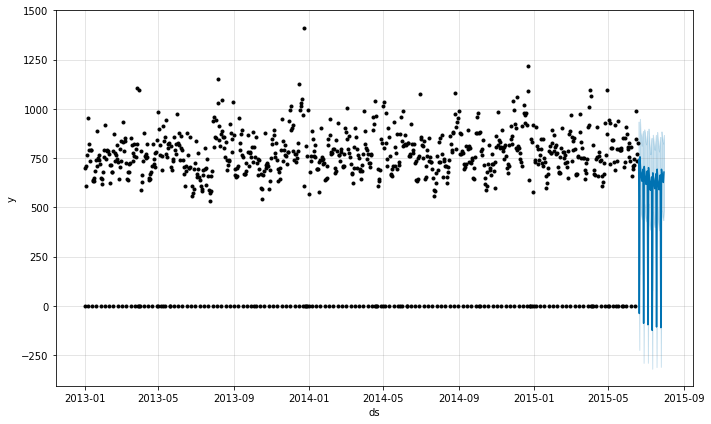

In [38]:
# Components

forecast, m = run_individ_forecast_w_reg_mod(100)
fig1 = m.plot(forecast)

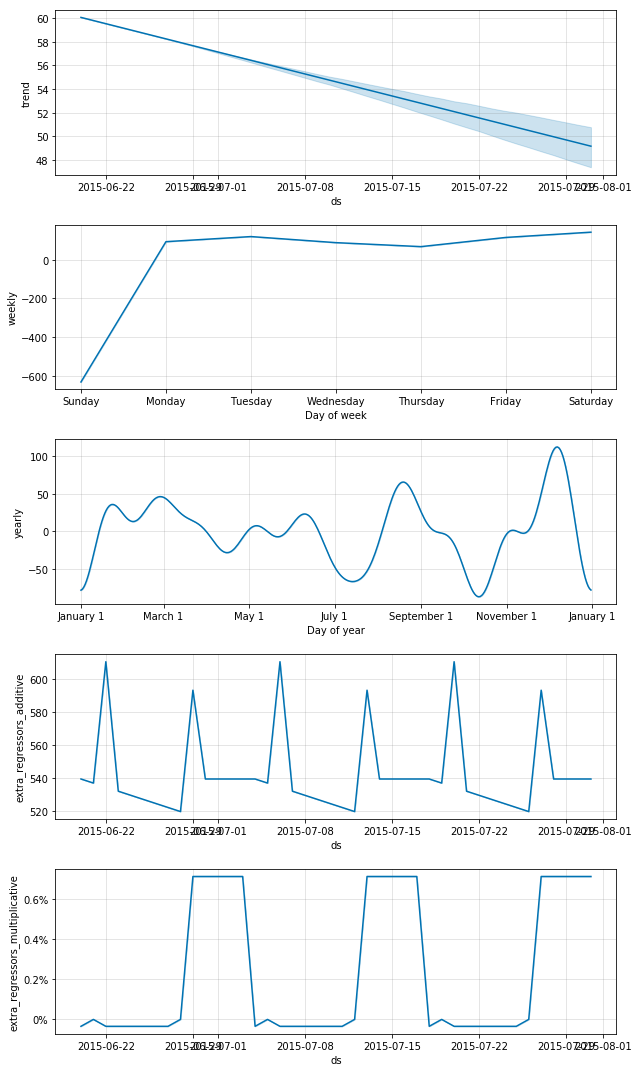

In [39]:
fig2 = m.plot_components(forecast)

In [40]:
combo = results.merge(results2,how='left',on=['Store','ds'],suffixes=('_1', '_2'))
combo.loc[:,'ds'] = pd.to_datetime(combo['ds'])
combo = combo.merge(fbtest,how='left',on=['Store','ds'],suffixes=('_pred','_test'))

In [41]:
combo.loc[:,'err_1'] = combo['y_1'] - combo['yhat_1']
combo.loc[:,'err_2'] = combo['y_2'] - combo['yhat_2']
combo.head(1).T

,0
Store,1
ds,2015-06-20 00:00:00
yhat_1,549.720
y_1,494
yhat_2,549.720
y_2,494
DayOfWeek,6
Sales,4097
y,494
Open,1.000


In [42]:
combo.loc[combo['y']!=0,['err_1','err_2']].median()

err_1   -18.252
err_2   -18.252
dtype: float64

In [43]:
combo.loc[combo['y']!=0,:].groupby('DayOfWeek')['err_1','err_2'].describe().T

DayOfWeek          1        2        3        4        5         6        7
err_1 count 6682.000 6682.000 6682.000 6680.000 6681.000  6682.000  193.000
      mean    -3.460  -14.428   -7.923   26.440   -2.931   -56.300   62.791
      std    130.533  130.872   99.711   90.198  101.529    86.809  150.566
      min   -649.022 -516.391 -557.259 -447.387 -530.745 -1202.108 -505.194
      25%    -93.659 -103.277  -71.229  -28.006  -65.788   -84.928   -5.128
      50%     -5.487  -30.519  -12.920   20.416  -17.355   -45.962   48.909
      75%     87.874   61.943   43.029   69.866   47.639   -15.875  115.219
      max    818.326  878.701  903.680  994.942  842.254   747.625  616.063
err_2 count 6682.000 6682.000 6682.000 6680.000 6681.000  6682.000  193.000
      mean    -3.460  -14.428   -7.923   26.440   -2.931   -56.300   62.791
      std    130.533  130.872   99.711   90.198  101.529    86.809  150.566
      min   -649.022 -516.391 -557.259 -447.387 -530.745 -1202.108 -505.194
      25%    -93.659 -103.277  -71.229  -28.006  -65.788   -84.928   -5.128
      50%     -5.487  -30.519  -12.920   20.416  -17.355   -45.962   48.909
      75%     87.874   61.943   43.029   69.866   47.639   -15.875  115.219
      max    818.326  878.701  903.680  994.942  842.254   747.625  616.063

In [44]:
combo.loc[combo['y']!=0,:].groupby('Promo')['err_1','err_2'].describe().T

Promo           0.000     1.000
err_1 count 23581.000 16701.000
      mean    -64.299    68.063
      std      85.229    96.339
      min   -1202.108  -557.259
      25%    -104.656    12.376
      50%     -58.812    56.843
      75%     -19.995   110.792
      max     842.254   994.942
err_2 count 23581.000 16701.000
      mean    -64.299    68.063
      std      85.229    96.339
      min   -1202.108  -557.259
      25%    -104.656    12.376
      50%     -58.812    56.843
      75%     -19.995   110.792
      max     842.254   994.942

In [45]:
combo.loc[combo['err_2']<-20000,:]

,Store,ds,yhat_1,y_1,yhat_2,y_2,DayOfWeek,Sales,y,Open,...,promo_dt,closed_dt,open_dt,prev_open_dt,daydiff_open_dt,prev_promo_dt,daydiff_promo_dt,floor,err_1,err_2


# GBM Version

https://machinelearningmastery.com/feature-selection-time-series-forecasting-python/

### Data Manipulation and Cleaning

In [251]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,promo_dt,closed_dt,open_dt,prev_open_dt,daydiff_open_dt,prev_promo_dt,daydiff_promo_dt
1016095,1,2,2013-01-01,0,0,0,0,a,1,c,...,nan,nan,NaN,NaT,2013-01-01,NaT,NaT,nan,NaT,nan
1014980,1,3,2013-01-02,5530,668,1,0,d,1,c,...,nan,nan,NaN,NaT,NaT,2013-01-02,NaT,nan,NaT,nan
1013865,1,4,2013-01-03,4327,578,1,0,d,1,c,...,nan,nan,NaN,NaT,NaT,2013-01-03,2013-01-02,0.000,NaT,nan
1012750,1,5,2013-01-04,4486,619,1,0,d,1,c,...,nan,nan,NaN,NaT,NaT,2013-01-04,2013-01-03,0.000,NaT,nan
1011635,1,6,2013-01-05,4997,635,1,0,d,1,c,...,nan,nan,NaN,NaT,NaT,2013-01-05,2013-01-04,0.000,NaT,nan


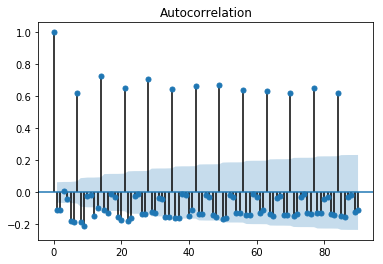

In [252]:
stores = df.Store.unique().tolist()
series = df.loc[df['Store']==stores[np.random.randint(0,len(stores))],'Customers'].values
plot_acf(series,lags=90)
pyplot.show()

# very strong weekly seasonality

In [286]:
## Removing Weekly Seasonality
def remove_lag_seasonality(dataframe, diff_col, new_col_nm, lag, remove_nulls=True):
    dataframe.loc[:,'og_days_prior'] = dataframe.groupby('Store')[diff_col].transform(lambda x:x.shift(lag))
    dataframe.loc[:,new_col_nm] = dataframe.loc[:,diff_col] - dataframe.loc[:,'og_days_prior']
    # remove null values
    if remove_nulls:
        dataframe = dataframe.loc[pd.notnull(dataframe[new_col_nm]),:]
    return dataframe

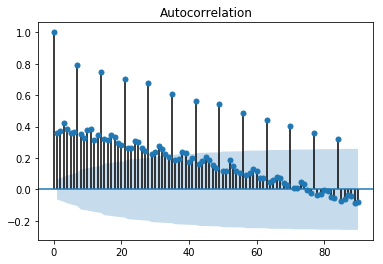

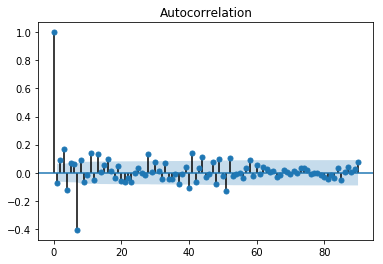

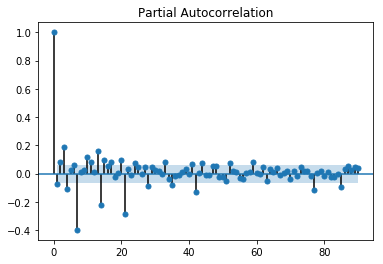

In [287]:
seas_adj = remove_lag_seasonality(df,'Customers','customer_strip_wkly',7)
seas_stores = seas_adj.Store.unique().tolist()
series = (seas_adj.loc[seas_adj['Store']==seas_stores[np.random.randint(0,len(seas_stores))],\
                       ['Date','Customers','customer_strip_wkly']])
# with seasonality
plot_acf(series['Customers'],lags=90)

# without seasonality
plot_acf(series['customer_strip_wkly'],lags=90)

# pacf w/o seas
plot_pacf(series['customer_strip_wkly'],lags=90)
pyplot.show()

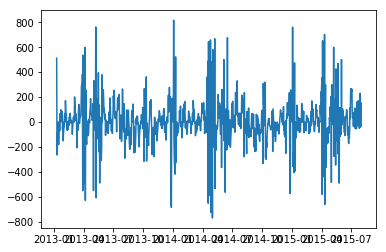

In [288]:
plt.plot(series[['Date','customer_strip_wkly']].set_index('Date'))
pyplot.show()

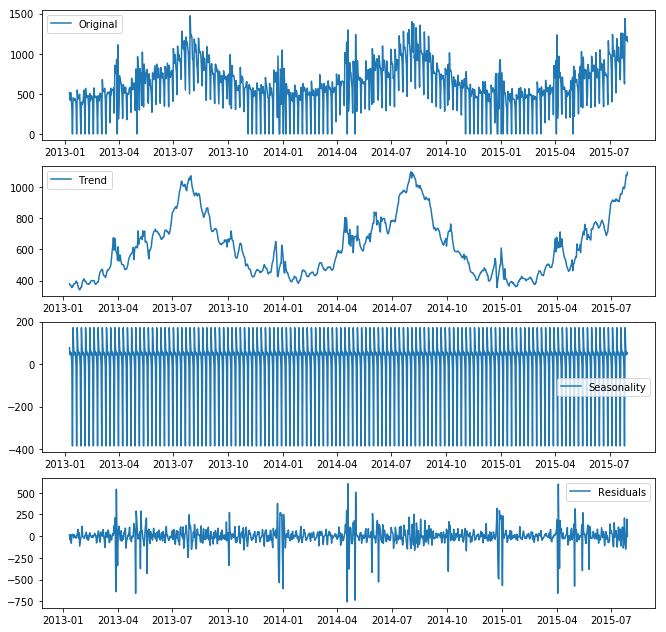

In [289]:
decomposition = seasonal_decompose(series[['Date','Customers']].set_index('Date'))

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax = plt.subplots(figsize=(11,11))
plt.subplot(411)
plt.plot(series[['Date','Customers']].set_index('Date'), label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()
# plt.tight_layout()

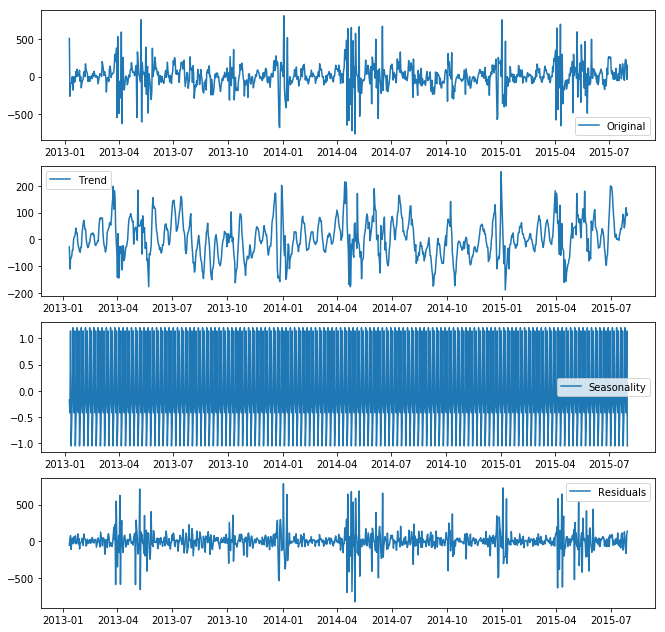

In [290]:
decomposition = seasonal_decompose(series[['Date','customer_strip_wkly']].set_index('Date'))

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax = plt.subplots(figsize=(11,11))
plt.subplot(411)
plt.plot(series[['Date','customer_strip_wkly']].set_index('Date'), label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()
# plt.tight_layout()

## Feature Generation (Building in Lags)

In [470]:
def build_feature_lags(dataframe,metric,max_lag):  
    dataframe = dataframe.sort_values(['Store','Date'])
    for e in np.arange(1,max_lag):
        dataframe.loc[:,'day'+str(e)+'_prior'] = (dataframe.groupby('Store')[metric]. \
                                                  transform(lambda x:x.shift(e)))
    dataframe.loc[:,'og_days_prior'] = (dataframe.groupby('Store')['Customers']. \
                                                  transform(lambda x:x.shift(7)))
    return(dataframe.loc[pd.notnull(dataframe['day7_prior']),:])

In [473]:
lag_seas_adj = build_feature_lags(seas_adj,metric='customer_strip_wkly',max_lag=35)

In [474]:
lag_seas_adj.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,day25_prior,day26_prior,day27_prior,day28_prior,day29_prior,day30_prior,day31_prior,day32_prior,day33_prior,day34_prior
1000485,1,2,2013-01-15,3900,512,1,0,d,0,c,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
999370,1,3,2013-01-16,4008,530,1,0,d,0,c,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
998255,1,4,2013-01-17,4044,503,1,0,d,0,c,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
997140,1,5,2013-01-18,4127,568,1,0,d,0,c,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
996025,1,6,2013-01-19,5182,688,1,0,d,0,c,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


## Start Modeling

In [475]:
# date masks
test_start_date = pd.to_datetime('2015-05-09') # this date leaves 42 days post
valid_start_date = pd.to_datetime('2015-06-20') # this date leaves 42 days post

gbmtrain = lag_seas_adj.loc[lag_seas_adj['Date']<test_start_date,:]
gbmtest = (lag_seas_adj.loc[(lag_seas_adj['Date']>=test_start_date) & 
                          (lag_seas_adj['Date']<valid_start_date),:])
gbmvalid = (lag_seas_adj.loc[lag_seas_adj['Date']>=valid_start_date,:])

In [476]:
h2otypes = h2o.H2OFrame(gbmtrain).types

def convert_pdf(dataframe):
    return(h2o.H2OFrame(dataframe,column_types = h2otypes))

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [477]:
param2 = {
    "ntrees" : 512,
    "nbins": 30,
    "min_rows":10,
    "max_depth":11,
    "learn_rate":0.1,
    "seed": 4241}

# Set up X and Y columns
features = [e for e in gbmtrain]
features.remove('Sales')
features.remove('Customers')
features.remove('open_dt')
features.remove('closed_dt')
features.remove('promo_dt')
features.remove('og_days_prior')
response = 'customer_strip_wkly'

In [478]:
# Specify Model
gbm = H2OGradientBoostingEstimator(**param2)
gbm.train(x=features, 
          y=response, 
          training_frame=convert_pdf(gbmtrain), 
          validation_frame=convert_pdf(gbmtest),
          min_split_improvement=0.99)

# Summary
gbm

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1551672763176_9


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 1849.2525131863447
RMSE: 43.002936099600745
MAE: 29.184651492826198
RMSLE: NaN
Mean Residual Deviance: 1849.2525131863447

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 9778.415684390257
RMSE: 98.88587201612906
MAE: 60.65063216799016
RMSLE: NaN
Mean Residual Deviance: 9778.415684390257
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2019-03-04 01:41:40,0.035 sec,0.0,264.0536474,154.8495692,69724.3286894,329.8645042,182.8714002,108810.5911281
,2019-03-04 01:41:41,1.392 sec,1.0,241.7606448,142.0096004,58448.2093804,301.3719522,167.6926642,90825.0535879
,2019-03-04 01:41:43,2.688 sec,2.0,221.9614312,130.6149981,49266.8769506,276.1925392,154.1079697,76282.3187254
,2019-03-04 01:41:44,3.908 sec,3.0,204.3141588,120.4543009,41744.2754763,254.4480887,142.6503236,64743.8298253
,2019-03-04 01:41:49,8.422 sec,7.0,151.8038390,90.4755561,23044.4055259,188.5214024,107.1427586,35540.3191782
---,---,---,---,---,---,---,---,---,---
,2019-03-04 01:47:01,5 min 20.955 sec,334.0,43.0029361,29.1846515,1849.2525132,98.8858720,60.6506322,9778.4156844
,2019-03-04 01:47:05,5 min 25.008 sec,378.0,43.0029361,29.1846515,1849.2525132,98.8858720,60.6506322,9778.4156844
,2019-03-04 01:47:09,5 min 29.015 sec,425.0,43.0029361,29.1846515,1849.2525132,98.8858720,60.6506322,9778.4156844
,2019-03-04 01:47:13,5 min 33.098 sec,471.0,43.0029361,29.1846515,1849.2525132,98.8858720,60.6506322,9778.4156844



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
day7_prior,119475642368.0000000,1.0,0.3686590
StateHoliday,76059385856.0000000,0.6366100,0.2346920
Promo,37366009856.0000000,0.3127500,0.1152981
day14_prior,12586072064.0000000,0.1053443,0.0388361
day1_prior,9523902464.0000000,0.0797142,0.0293874
---,---,---,---
CompetitionOpenSinceMonth,210836672.0000000,0.0017647,0.0006506
Promo2SinceYear,153384928.0000000,0.0012838,0.0004733
CompetitionOpenSinceYear,147479728.0000000,0.0012344,0.0004551
PromoInterval,70555496.0000000,0.0005905,0.0002177



See the whole table with table.as_data_frame()


In [228]:
model_path = h2o.save_model(model=gbm, path="/tmp/", force=True)

print(model_path)
# /tmp/GBM_model_python_1551660546646_3

# load the model
saved_model = h2o.load_model(model_path)

/tmp/GBM_model_python_1551660546646_3


In [211]:
# prediction = gbm.predict(df_valid)[:,2]

## One Step at a Time Prediction

In [481]:
pre = pd.concat([gbmtrain.copy(),gbmtest.copy()])
preds = pd.DataFrame()

test_dates = pd.to_datetime(gbmvalid['Date'].sort_values().unique())
for e in test_dates:
    print('working on',str(e))
    cp = gbmvalid.loc[gbmvalid['Date']==e,:].copy()
    cols = ['day7_prior', 'customer_strip_wkly', 'day1_prior',
           'day2_prior', 'day3_prior', 'day4_prior', 'day5_prior', 'day6_prior',
           'og_days_prior']
    cp.loc[:,cols] = np.NaN
    cp = pd.concat([cp,preds,pre],sort=True)
    cp = build_feature_lags(cp,'customer_strip_wkly',max_lag=35)
    cp = cp.loc[cp['Date']==e,:]
    cp.loc[:,'actual_customers'] = cp.loc[:,'Customers']
    out = gbm.predict(convert_pdf(cp))
    cp.loc[:,'predict'] = out.as_data_frame()['predict'].values
    cp.loc[:,'customer_strip_wkly'] = cp.loc[:,'predict']
    cp.loc[:,'Customers'] = cp.loc[:,'predict'] + cp.loc[:,'og_days_prior']
    preds = pd.concat([preds,cp],sort=True)
    
preds.loc[:,'y'] = preds.loc[:,'actual_customers']
preds.loc[:,'yhat'] = preds.loc[:,'Customers']

working on 2015-06-20 00:00:00
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
working on 2015-06-21 00:00:00
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
working on 2015-06-22 00:00:00
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
working on 2015-06-23 00:00:00
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
working on 2015-06-24 00:00:00
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
working on 2015-06-25 00:00:00
Pars

In [482]:
preds.loc[:,'y'] = preds.loc[:,'actual_customers']
preds.loc[:,'yhat'] = preds.loc[:,'Customers']
rmse(preds)

102.41573224555735

## Error Analysis

In [276]:
lag_seas_adj.groupby('Open')['customer_strip_wkly'].mean()

Open
0   -130.541
1     26.928
Name: customer_strip_wkly, dtype: float64

In [231]:
preds.groupby('DayOfWeek').apply(rmse)

DayOfWeek
1   117.536
2   110.827
3   103.502
4   102.542
5   115.402
6    93.365
7   151.049
dtype: float64

In [235]:
preds.groupby('Promo').apply(rmse)

Promo
0   104.538
1   112.169
dtype: float64

In [236]:
preds.groupby('Assortment').apply(rmse)

Assortment
a   103.064
b   239.517
c   108.735
dtype: float64

In [237]:
preds.groupby('Open').apply(rmse)

Open
0       nan
1   107.768
dtype: float64

In [483]:
preds.loc[:,'err'] = preds.loc[:,'y'] - preds.loc[:,'yhat']
preds.sort_values('err',ascending=False).head()

,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Customers,Date,DayOfWeek,Open,Promo,Promo2,...,daydiff_promo_dt,og_days_prior,open_dt,predict,prev_open_dt,prev_promo_dt,promo_dt,y,yhat,err
13173,c,1680.000,nan,nan,267.968,2015-07-20,1,1,0,1,...,2.000,270.050,2015-07-20,-2.082,2015-07-18,2015-07-17,NaT,1767.000,267.968,1499.032
6523,a,870.000,3.000,2006.000,-1235.157,2015-07-26,7,0,0,0,...,8.000,-874.305,NaT,-360.852,2015-07-25,2015-07-17,NaT,0.000,-1235.157,1235.157
5942,c,1450.000,4.000,2005.000,-1195.170,2015-07-26,7,0,0,1,...,8.000,-847.861,NaT,-347.308,2015-07-25,2015-07-17,NaT,0.000,-1195.170,1195.170
5621,c,270.000,4.000,2013.000,-1185.407,2015-07-26,7,0,0,1,...,8.000,-813.310,NaT,-372.097,2015-07-25,2015-07-17,NaT,0.000,-1185.407,1185.407
6076,a,220.000,2.000,2002.000,-1174.682,2015-07-26,7,0,0,1,...,8.000,-924.954,NaT,-249.728,2015-07-25,2015-07-17,NaT,0.000,-1174.682,1174.682


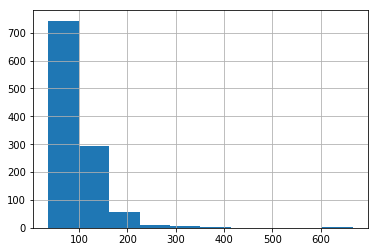

In [241]:
preds.groupby('Store').apply(rmse).reset_index().iloc[:,1].hist()

In [239]:
preds.sort_values('err',ascending=False).head(1).T

,13173
Assortment,c
CompetitionDistance,1680.000
CompetitionOpenSinceMonth,NaN
CompetitionOpenSinceYear,NaN
Customers,473.866
Date,2015-07-20 00:00:00
DayOfWeek,1
Open,1
Promo,0
Promo2,1


In [484]:
pre.loc[:,'y'] = pre.loc[:,'Customers']
plotdf = pd.concat([pre,preds],sort=True)

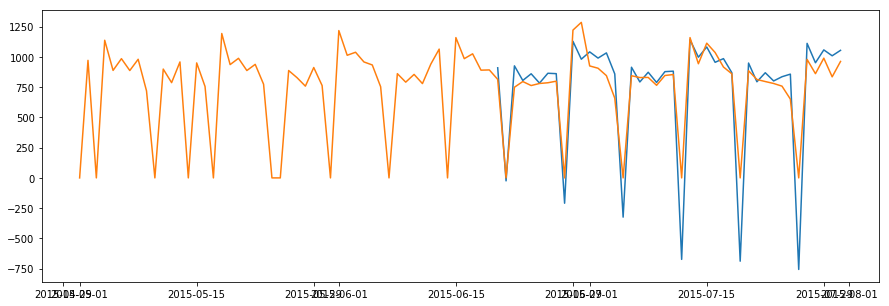

In [490]:
def plotter(dataframe,idx,start=pd.to_datetime('2015-05-01')):
    idf = dataframe.loc[(dataframe['Store']==idx)&(dataframe['Date']>=start),:]
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(idf.Date,idf.yhat)
    ax.plot(idf.Date,idf.y)
    plt.show()
    
plotter(plotdf,12)

## Version without differencing

In [ ]:
h2o.init(max_mem_size="25G")

In [422]:
print(time.time())

1551674794.4641454


In [463]:
# GBM hyperparameters
gbm_params2 = {'learn_rate': [i*0.02 for i in range(3, 7)],
               'max_depth': [4,7,9,11],
               'min_rows': [10*i for i in range(1,150)],
               'ntrees':[2**i for i in range(5, 11)],
               'sample_rate':[0.9,1]}

# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 24, 'seed': 1, 'max_runtime_secs': 1800}

# Train and validate a random grid of GBMs
gbm_grid2 = h2o.grid.H2OGridSearch(
    model=H2OGradientBoostingEstimator,
    hyper_params=gbm_params2,
    search_criteria=search_criteria)

gbm_grid2.train(x=features,
                y="Customers",
                training_frame=convert_pdf(gbmtrain),
                validation_frame=convert_pdf(gbmtest),
                stopping_tolerance=0.99)

gbm_gridperf2 = gbm_grid2.get_grid(sort_by='rmse', decreasing=False)
gbm_gridperf2

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |██████████ (cancelled)


H2OJobCancelled: Job<$03017f00000132d4ffffffff$_934d9790419911071314159c202a4583> was cancelled by the user.

In [402]:
# Columns
features = [e for e in gbmtrain]
features.remove('Sales')
features.remove('Customers')
features.remove('open_dt')
features.remove('closed_dt')
features.remove('promo_dt')
features.remove('og_days_prior')
features.remove('customer_strip_wkly')
response = 'Customers'

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,12 mins 48 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.2
H2O cluster version age:,1 month and 12 days
H2O cluster name:,H2O_from_python_paperspace_eof3zz
H2O cluster total nodes:,1
H2O cluster free memory:,21.34 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1551672763176_4


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 3820.1375428060987
RMSE: 61.80726124660515
MAE: 39.04922086100255
RMSLE: NaN
Mean Residual Deviance: 3820.1375428060987

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 5014.0827682300915
RMSE: 70.81018830811065
MAE: 44.74496160118215
RMSLE: NaN
Mean Residual Deviance: 5014.0827682300915
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2019-03-03 23:26:36,0.024 sec,0.0,465.3508675,324.6084890,216551.4298503,473.1507200,331.0066431,223871.6038264
,2019-03-03 23:26:37,1.177 sec,1.0,420.8887542,294.0299130,177147.3434236,427.2519088,299.2481873,182544.1935512
,2019-03-03 23:26:38,2.240 sec,2.0,380.9285879,266.4925072,145106.5890447,385.9352714,270.6485357,148946.0336890
,2019-03-03 23:26:39,3.221 sec,3.0,345.1125632,241.8083236,119102.6813005,349.1108080,245.2254713,121878.3562513
,2019-03-03 23:26:44,7.419 sec,7.0,235.4450532,166.0910107,55434.3730716,236.1033334,166.8721153,55744.7840194
---,---,---,---,---,---,---,---,---,---
,2019-03-03 23:28:00,1 min 23.710 sec,371.0,61.8072612,39.0492209,3820.1375428,70.8101883,44.7449616,5014.0827682
,2019-03-03 23:28:04,1 min 27.715 sec,411.0,61.8072612,39.0492209,3820.1375428,70.8101883,44.7449616,5014.0827682
,2019-03-03 23:28:08,1 min 31.784 sec,451.0,61.8072612,39.0492209,3820.1375428,70.8101883,44.7449616,5014.0827682
,2019-03-03 23:28:12,1 min 35.829 sec,491.0,61.8072612,39.0492209,3820.1375428,70.8101883,44.7449616,5014.0827682



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
day14_prior,455099777024.0000000,1.0,0.4477340
Open,387916267520.0000000,0.8523763,0.3816378
day28_prior,83661537280.0000000,0.1838312,0.0823075
day1_prior,20904742912.0000000,0.0459344,0.0205664
day7_prior,18456891392.0000000,0.0405557,0.0181582
---,---,---,---
CompetitionOpenSinceYear,85312464.0000000,0.0001875,0.0000839
CompetitionOpenSinceMonth,83064464.0000000,0.0001825,0.0000817
Promo2SinceYear,52474568.0000000,0.0001153,0.0000516
PromoInterval,27753018.0000000,0.0000610,0.0000273



See the whole table with table.as_data_frame()


In [464]:
# Specify Model
param2 = {
    "ntrees" : 512,
    "nbins": 30,
    "min_rows":10,
    "max_depth":11,
    "learn_rate":0.1,
    "seed": 4241}

gbm2 = H2OGradientBoostingEstimator(**param2)
gbm2.train(x=features, 
           y='Customers', 
           training_frame=convert_pdf(gbmtrain), 
           validation_frame=convert_pdf(gbmtest))

# Summary
gbm2

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1551672763176_8


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 2306.2418414919466
RMSE: 48.023346837678304
MAE: 31.313039619551134
RMSLE: NaN
Mean Residual Deviance: 2306.2418414919466

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 5044.290203718694
RMSE: 71.02316666918404
MAE: 45.49408132463689
RMSLE: NaN
Mean Residual Deviance: 5044.290203718694
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2019-03-04 01:33:36,0.029 sec,0.0,465.3508675,324.6084890,216551.4298503,473.1507200,331.0066431,223871.6038264
,2019-03-04 01:33:36,0.987 sec,1.0,420.8887542,294.0299130,177147.3434236,427.2519088,299.2481873,182544.1935512
,2019-03-04 01:33:37,1.918 sec,2.0,380.9285879,266.4925072,145106.5890447,385.9352714,270.6485357,148946.0336890
,2019-03-04 01:33:38,2.971 sec,3.0,345.1125632,241.8083236,119102.6813005,349.1108080,245.2254713,121878.3562513
,2019-03-04 01:33:39,3.901 sec,4.0,312.9998390,219.6995267,97968.8992347,315.8898518,222.1441979,99786.3985015
---,---,---,---,---,---,---,---,---,---
,2019-03-04 01:36:03,2 min 27.149 sec,356.0,48.0233468,31.3130396,2306.2418415,71.0231667,45.4940813,5044.2902037
,2019-03-04 01:36:07,2 min 31.199 sec,400.0,48.0233468,31.3130396,2306.2418415,71.0231667,45.4940813,5044.2902037
,2019-03-04 01:36:11,2 min 35.201 sec,443.0,48.0233468,31.3130396,2306.2418415,71.0231667,45.4940813,5044.2902037
,2019-03-04 01:36:15,2 min 39.252 sec,488.0,48.0233468,31.3130396,2306.2418415,71.0231667,45.4940813,5044.2902037



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
day14_prior,455321747456.0000000,1.0,0.4447963
Open,387950280704.0000000,0.8520355,0.3789822
day28_prior,83793076224.0000000,0.1840305,0.0818561
day1_prior,21212784640.0000000,0.0465886,0.0207224
day7_prior,18563905536.0000000,0.0407710,0.0181348
---,---,---,---
Assortment,155562496.0000000,0.0003417,0.0001520
CompetitionOpenSinceMonth,149009392.0000000,0.0003273,0.0001456
PromoInterval,117527960.0000000,0.0002581,0.0001148
Promo2SinceYear,106685352.0000000,0.0002343,0.0001042



See the whole table with table.as_data_frame()


In [466]:
model_path = h2o.save_model(model=gbm2, path="/tmp/", force=True)

print(model_path)
# /tmp/GBM_model_python_1551660546646_3

# load the model
saved_model = h2o.load_model(model_path)

/tmp/GBM_model_python_1551672763176_8


In [467]:
gbm2.scoring_history()

,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2019-03-04 01:33:36,0.029 sec,0.000,465.351,324.608,216551.430,473.151,331.007,223871.604
1,,2019-03-04 01:33:36,0.987 sec,1.000,420.889,294.030,177147.343,427.252,299.248,182544.194
2,,2019-03-04 01:33:37,1.918 sec,2.000,380.929,266.493,145106.589,385.935,270.649,148946.034
3,,2019-03-04 01:33:38,2.971 sec,3.000,345.113,241.808,119102.681,349.111,245.225,121878.356
4,,2019-03-04 01:33:39,3.901 sec,4.000,313.000,219.700,97968.899,315.890,222.144,99786.399
5,,2019-03-04 01:33:44,8.428 sec,9.000,196.558,139.144,38635.222,196.099,139.117,38454.714
6,,2019-03-04 01:33:48,12.944 sec,14.000,131.318,93.660,17244.525,129.345,92.633,16730.108
7,,2019-03-04 01:33:53,17.623 sec,19.000,96.841,68.705,9378.267,95.991,68.729,9214.185
8,,2019-03-04 01:33:58,22.188 sec,24.000,79.508,55.181,6321.558,80.654,56.558,6505.021
9,,2019-03-04 01:34:02,26.917 sec,29.000,70.851,47.722,5019.866,74.474,50.452,5546.442


In [469]:
pd.DataFrame(gbm2.varimp())

,0,1,2,3
0,day14_prior,455321747456.000,1.000,0.445
1,Open,387950280704.000,0.852,0.379
2,day28_prior,83793076224.000,0.184,0.082
3,day1_prior,21212784640.000,0.047,0.021
4,day7_prior,18563905536.000,0.041,0.018
5,day2_prior,10759094272.000,0.024,0.011
6,Promo,6193510400.000,0.014,0.006
7,day21_prior,5782602752.000,0.013,0.006
8,day3_prior,5583952384.000,0.012,0.005
9,Date,2241039104.000,0.005,0.002


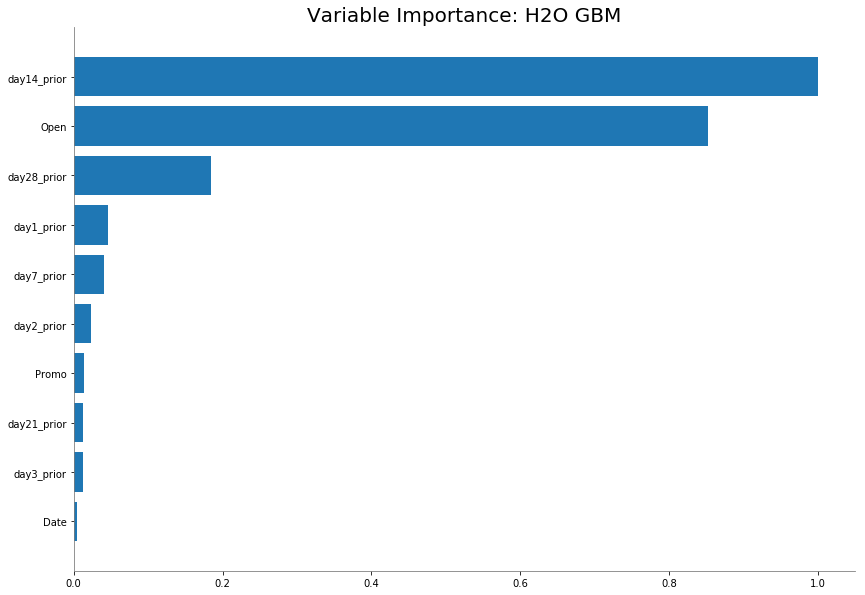

In [468]:
gbm2.varimp_plot()

In [405]:
pre = pd.concat([gbmtrain.copy(),gbmtest.copy()])
preds = pd.DataFrame()

test_dates = pd.to_datetime(gbmvalid['Date'].sort_values().unique())
for e in test_dates:
    print('working on',str(e))
    cp = gbmvalid.loc[gbmvalid['Date']==e,:].copy()
    cols = ['day7_prior', 'customer_strip_wkly', 'day1_prior',
           'day2_prior', 'day3_prior', 'day4_prior', 'day5_prior', 'day6_prior',
           'og_days_prior']
    cp.loc[:,cols] = np.NaN
    cp = pd.concat([cp,preds,pre],sort=True)
    cp = build_feature_lags(cp,metric='Customers',max_lag=30)
    cp = cp.loc[cp['Date']==e,:]
    cp.loc[:,'actual_customers'] = cp.loc[:,'Customers']
    out = gbm2.predict(convert_pdf(cp))
    cp.loc[:,'Customers'] = out.as_data_frame()['predict'].values
    preds = pd.concat([preds,cp],sort=True)
    
preds.loc[:,'y'] = preds.loc[:,'actual_customers']
preds.loc[:,'yhat'] = preds.loc[:,'Customers']

working on 2015-06-20 00:00:00
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
working on 2015-06-21 00:00:00
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
working on 2015-06-22 00:00:00
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
working on 2015-06-23 00:00:00
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
working on 2015-06-24 00:00:00
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
working on 2015-06-25 00:00:00
Pars

In [446]:
preds.loc[:,'y'] = preds.loc[:,'actual_customers']
preds.loc[:,'yhat'] = preds.loc[:,'Customers']
print(rmse(preds)) #99 rmse for gbm w/ params

99.94460988488201


73.24699201673135

In [407]:
pre.loc[:,'y'] = pre.loc[:,'Customers']
plotdf = pd.concat([pre,preds],sort=True)
plotdf.loc[:,'err'] = plotdf['yhat'] - plotdf['y']

In [408]:
plotdf.groupby('Store').apply(rmse).reset_index().sort_values(0,ascending=False).head(20)

,Store,0
768,769,372.876
908,909,369.554
268,269,368.304
875,876,320.132
529,530,315.404
1113,1114,312.796
1096,1097,283.999
291,292,282.409
585,586,280.894
250,251,278.528


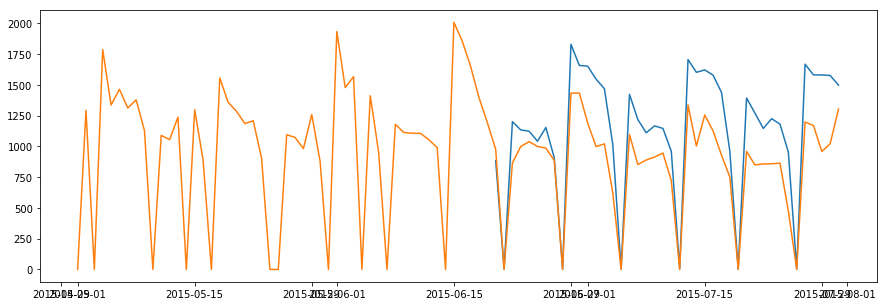

In [413]:
plotter(plotdf,269)

In [414]:
preds.groupby('DayOfWeek').apply(rmse)

DayOfWeek
1   102.547
2    99.831
3    98.483
4   108.518
5    97.644
6    89.909
7   149.699
dtype: float64

In [419]:
preds.groupby('Assortment').apply(rmse)

Assortment
a    93.348
b   235.624
c   102.613
dtype: float64

In [416]:
preds.groupby('Promo').apply(rmse)

Promo
0    85.866
1   116.973
dtype: float64

In [421]:
gbm2.scoring_history()

,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2019-03-03 23:26:36,0.024 sec,0.000,465.351,324.608,216551.430,473.151,331.007,223871.604
1,,2019-03-03 23:26:37,1.177 sec,1.000,420.889,294.030,177147.343,427.252,299.248,182544.194
2,,2019-03-03 23:26:38,2.240 sec,2.000,380.929,266.493,145106.589,385.935,270.649,148946.034
3,,2019-03-03 23:26:39,3.221 sec,3.000,345.113,241.808,119102.681,349.111,245.225,121878.356
4,,2019-03-03 23:26:44,7.419 sec,7.000,235.445,166.091,55434.373,236.103,166.872,55744.784
5,,2019-03-03 23:26:49,12.464 sec,12.000,152.825,108.717,23355.390,151.105,107.796,22832.806
6,,2019-03-03 23:26:53,16.573 sec,15.000,122.486,87.390,15002.754,120.618,86.483,14548.636
7,,2019-03-03 23:26:57,20.871 sec,19.000,96.854,68.706,9380.683,96.101,68.822,9235.361
8,,2019-03-03 23:27:01,25.276 sec,23.000,82.077,57.264,6736.596,82.664,58.301,6833.327
9,,2019-03-03 23:27:06,30.100 sec,27.000,73.703,50.225,5432.097,76.257,52.412,5815.124


# Please Don't Go Further

## First Model (LSTM)

First, let's try use Seq2Seq in order to see if this is a good way of forecasting. I am following this tutorial: https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Intro.ipynb

In [ ]:
train.head(3)

In [ ]:
train.columns[1]

In [ ]:
data_start_date = train.columns[1]
data_end_date = train.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

In [ ]:
def plot_random_series(train, n_series):
    
    sample = train.sample(n_series, random_state=8)
    page_labels = sample['Store'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        pd.Series(series_samples.iloc[i]).astype(np.float64).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Daily Store Sales')
    plt.legend(page_labels)
    
plot_random_series(train, 3)

In [ ]:
from datetime import timedelta

pred_steps = 14
pred_length = timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

In [ ]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in train.columns[1:]]),
                          data=[i for i in range(len(train.columns[1:]))])

series_array = train[train.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.nan_to_num(series_array) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from keras.optimizers import Adam
from keras.layers.recurrent import LSTM

# convolutional layer parameters
n_filters = 32
filter_width = 2
dilation_rates = [2**i for i in range(8)]

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.5)(x)
x = Dense(1)(x)

# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':14})(x)

model = Model(history_seq, pred_seq_train)

model.summary()

In [ ]:
first_n_samples = 1000
batch_size = 128
epochs = 10

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# okay, so for each one of these, 
# 1) for the encoder portion, we first take each series and subtract the mean
# 2) for the decoder portion, we find the prediction (last 2 weeks) and then set that up with the same transformations

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

# here, we are adding the lagged history of the target series to the input data at the end
# looks like, train then test-1 day


In [ ]:
model.compile(Adam(), loss='mean_absolute_percentage_error')
history = model.fit(encoder_input_data, 
                    decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Percentage Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [ ]:
def predict_sequence(input_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

In [ ]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [ ]:
encode_series_mean[0:1]

In [ ]:
def predict_and_plot(encoder_input_data, encode_series_mean, decoder_target_data, sample_ind, enc_tail_len=14):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    encode_series_mean = encode_series_mean[sample_ind:sample_ind+1] 
    pred_series = predict_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    encode_series += encode_series_mean
    pred_series = pred_series.reshape(-1,1)
    pred_series += encode_series_mean
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    target_series += encode_series_mean
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

In [ ]:
predict_and_plot(encoder_input_data, encode_series_mean, decoder_target_data,0)

issues with install: https://forums.fast.ai/t/fastai-v0-7-install-issues-thread/24652 

## Try version with actual LSTM

https://github.com/jfpuget/Kaggle/blob/master/WebTrafficPrediction/keras_simple.ipynb